In [1]:
# Import required libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.applications import MobileNetV2, VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import os
import cv2
import seaborn as sns

**/kaggle/input/dataset-of-77-bangla-sign/Final_Processed_images**

In [2]:
# Define Dataset Paths and Preprocess
class_path1 = "/kaggle/input/dataset-of-77-bangla-sign/Final_Processed_images"
class1 = sorted(os.listdir(class_path1))

CLASSES = class1
CLASSES = [class_name.replace(" ", "").lower() for class_name in CLASSES]

# Set dataset directory (change path as needed)
dataset_path = "/kaggle/input/dataset-of-77-bangla-sign/Final_Processed_images"
IMG_SIZE = 128  # Resize images to 128x128
CHANNELS = 3  # Use 1 for Grayscale images
LEN = sorted(os.listdir(dataset_path))  # Class names based on folder names

In [3]:
# Load dataset and preprocess
data = []
labels = []

for label, class_name in enumerate(LEN):
    class_path = os.path.join(dataset_path, class_name)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        try:
            # Read, resize, and normalize the image
            img = cv2.imread(img_path)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize images
            img = img / 255.0  # Normalize
            data.append(img)
            labels.append(class_name.strip())
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")


print("done image loading")

done image loading


In [4]:
# Preprocess labels
labels = [label.replace(" ", "").lower() for label in labels]
label_mapping = {class_name: index for index, class_name in enumerate(CLASSES)}

# Convert string labels to numeric labels using the mapping
numeric_labels = [label_mapping[label] for label in labels]

# print(numeric_labels)

# Convert data and labels to NumPy arrays
data = np.array(data, dtype=np.float32)
labels = np.array(numeric_labels, dtype=np.float32)

print(labels)

[ 0.  0.  0. ... 76. 76. 76.]


In [6]:
print(label_mapping)

{'aaj': 0, 'basha': 1, 'biyog': 2, 'bondhu': 3, 'darano': 4, 'darao': 5, 'desh': 6, 'ekhane': 7, 'gun': 8, 'kichuta': 9, 'kothay': 10, 'onurodh': 11, 'shahajjo': 12, 'she': 13, 'shomoi': 14, 'shundor': 15, 'sign0': 16, 'sign00': 17, 'sign01': 18, 'sign02': 19, 'sign03': 20, 'sign04': 21, 'sign05': 22, 'sign06': 23, 'sign07': 24, 'sign08': 25, 'sign09': 26, 'sign1': 27, 'sign10': 28, 'sign11': 29, 'sign12': 30, 'sign13': 31, 'sign14': 32, 'sign15': 33, 'sign16': 34, 'sign17': 35, 'sign18': 36, 'sign19': 37, 'sign2': 38, 'sign20': 39, 'sign21': 40, 'sign22': 41, 'sign23': 42, 'sign24': 43, 'sign25': 44, 'sign26': 45, 'sign27': 46, 'sign28': 47, 'sign29': 48, 'sign3': 49, 'sign30': 50, 'sign31': 51, 'sign32': 52, 'sign33': 53, 'sign34': 54, 'sign35': 55, 'sign36': 56, 'sign4': 57, 'sign5': 58, 'sign6': 59, 'sign7': 60, 'sign8': 61, 'sign9': 62, 'sir': 63, 'tara': 64, 'tumi': 65, 'bagh': 66, 'bouddho': 67, 'chamra': 68, 'girja': 69, 'hockey': 70, 'jail': 71, 'keram': 72, 'piano': 73, 'puru

In [5]:
import json

# Create reverse mapping
index_to_label = {v: k for k, v in label_mapping.items()}

# Save to JSON
with open('label_mapping.json', 'w') as f:
    json.dump(index_to_label, f)


In [8]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42, stratify=labels)

In [11]:
# One-hot encode labels for deep learning models
y_train_dl = tf.keras.utils.to_categorical(y_train, num_classes=len(CLASSES))
y_test_dl = tf.keras.utils.to_categorical(y_test, num_classes=len(CLASSES))

# Flatten data for machine learning models
X_train_flattened = X_train.reshape(X_train.shape[0], -1)
X_test_flattened = X_test.reshape(X_test.shape[0], -1)
y_train_flat = y_train.astype(int)
y_test_flat = y_test.astype(int)

In [12]:
def display_metrics(y_true, y_pred, model_name):
    # Calculate metrics
    acc = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    cm = confusion_matrix(y_true, y_pred)

    # Plot metrics as a bar chart
    metrics = {'Accuracy': acc, 'Recall': recall, 'F1 Score': f1}
    plt.figure(figsize=(8, 5))
    plt.bar(metrics.keys(), metrics.values(), color=['skyblue', 'lightgreen', 'salmon'])
    plt.title(' ', fontsize=16)
    plt.ylim(0, 1)
    plt.ylabel('Score', fontsize=14)
    plt.xlabel('Metrics', fontsize=14)
    for i, (metric, value) in enumerate(metrics.items()):
        plt.text(i, value + 0.02, f'{value:.4f}', ha='center', fontsize=12)
    plt.show()

    # Plot confusion matrix as a heatmap
    plt.figure(figsize=(30, 30))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=True, yticklabels=True)
    plt.title(f'{model_name} Confusion Matrix', fontsize=24)
    plt.xlabel('Predicted Labels', fontsize=24)
    plt.ylabel('True Labels', fontsize=24)
    plt.show()

    return acc, recall, f1

In [13]:
def build_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        BatchNormalization(),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),

        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),

        Flatten(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [14]:
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, restore_best_weights=True),
    ModelCheckpoint("cnn_model.keras", monitor='val_accuracy', save_best_only=True, verbose=1)
]


In [15]:
def build_mobilenet_model(input_shape, num_classes):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze base model

    model = Sequential([
        base_model,
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [16]:
def build_vgg16_model(input_shape, num_classes):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze base model

    model = Sequential([
        base_model,
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


I0000 00:00:1748007820.432892      95 service.cc:145] XLA service 0x7c04b0011600 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748007820.432952      95 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  37/1205 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.0377 - loss: 4.8439

I0000 00:00:1748007824.701925      95 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1205/1205 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3460 - loss: 2.7160

I0000 00:00:1748007833.236140      93 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_multiply_reduce_subtract_fusion', 8 bytes spill stores, 8 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_fusion_3', 16 bytes spill stores, 16 bytes spill loads



1205/1205 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.3462 - loss: 2.7151 - val_accuracy: 0.7523 - val_loss: 0.8580
Epoch 2/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8606 - loss: 0.4806 - val_accuracy: 0.8005 - val_loss: 0.6907
Epoch 3/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9193 - loss: 0.2670 - val_accuracy: 0.7692 - val_loss: 0.8483
Epoch 4/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9377 - loss: 0.2048 - val_accuracy: 0.9154 - val_loss: 0.3008
Epoch 5/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9485 - loss: 0.1645 - val_accuracy: 0.9249 - val_loss: 0.2686
Epoch 6/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9549 - loss: 0.1500 - val_accuracy: 0.9367 - val_loss: 0.2234
Epoch 7/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9605 - loss: 0.1280 - val_accuracy: 0.9376 - val_loss: 0.2288
Epoch 8/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9589 - loss: 0.1316 - val_accura

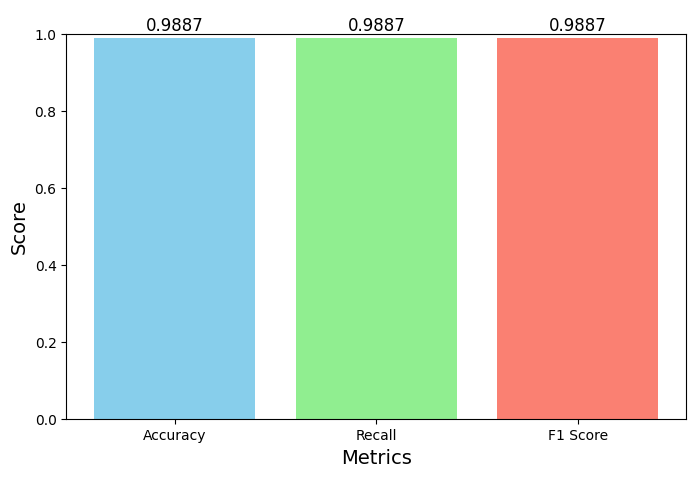

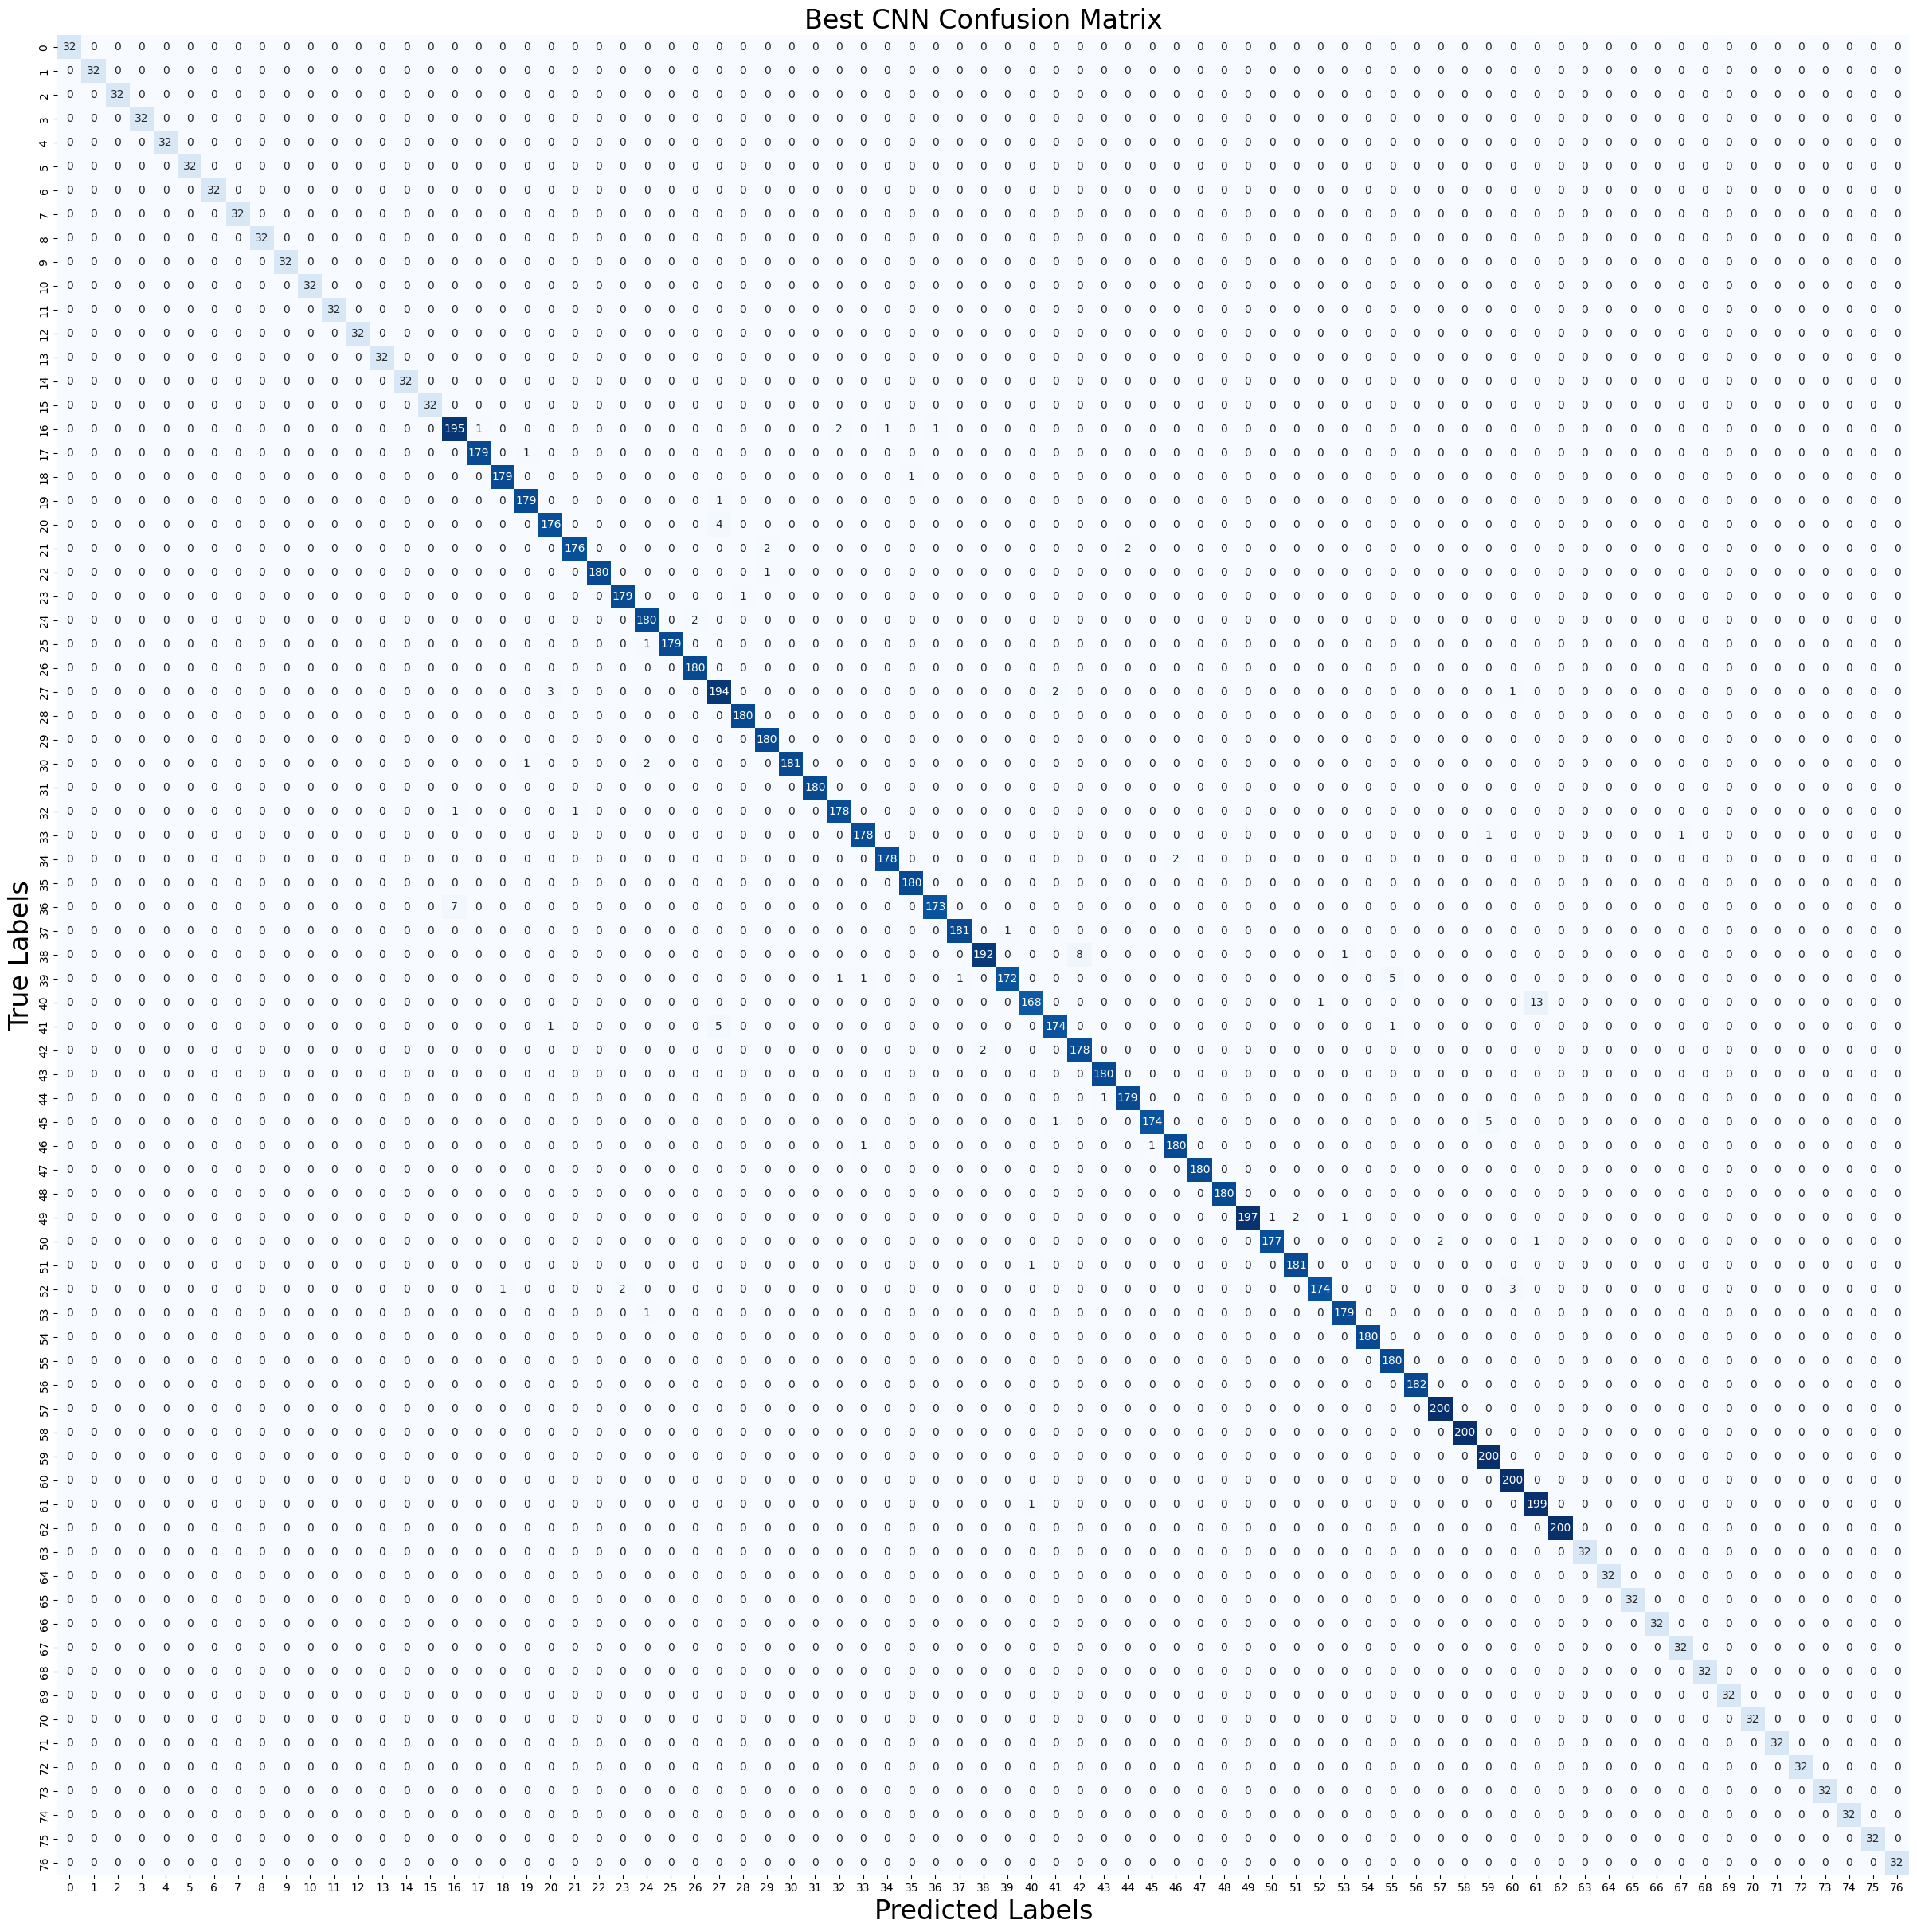

In [17]:
cnn_model = build_cnn_model(input_shape=(IMG_SIZE, IMG_SIZE, CHANNELS), num_classes=len(CLASSES))
history_cnn = cnn_model.fit(X_train, y_train_dl, validation_data=(X_test, y_test_dl), epochs=50, callbacks=callbacks, batch_size=32)

cnn_eval = cnn_model.evaluate(X_test, y_test_dl, verbose=0)
print(f"CNN Model - Test Accuracy: {cnn_eval[1]:.4f}")
# CNN Evaluation
cnn_predictions = cnn_model.predict(X_test)
display_metrics(y_test_dl.argmax(axis=1), cnn_predictions.argmax(axis=1), "Best CNN")
cnn_model.save("cnn_model.keras")

In [18]:
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 31, 31, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 6, 6, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 77)             │         9,933 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,081,193 (7.94 MB)

 Trainable params: 693,581 (2.65 MB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 1,387,164 (5.29 MB)

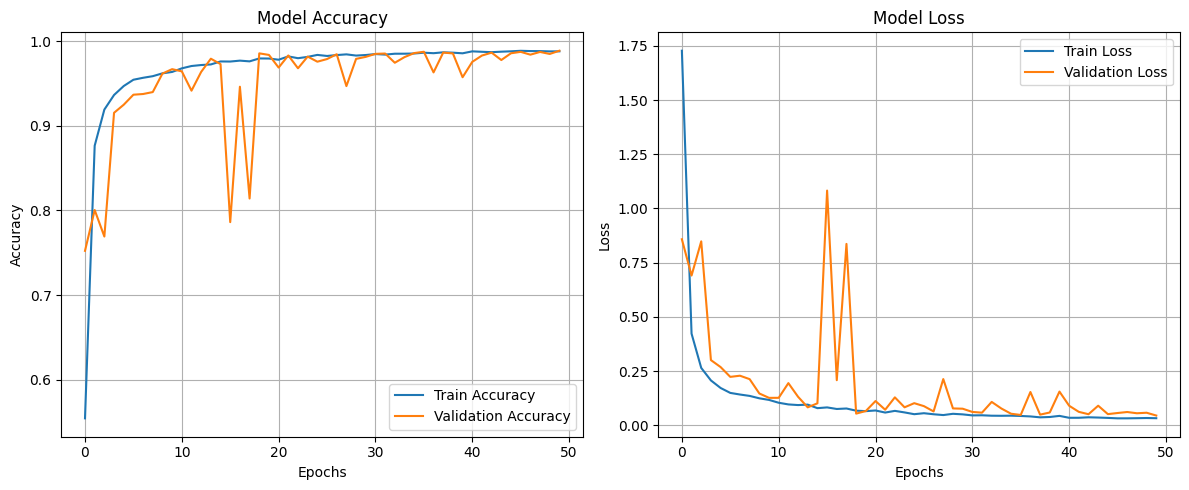

In [19]:
import matplotlib.pyplot as plt

# Plot accuracy graph
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.grid()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['loss'], label='Train Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.grid()

# Show the plots
plt.tight_layout()
plt.show()


In [ ]:
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, restore_best_weights=True),
    ModelCheckpoint("mobilenet_model.keras", monitor='val_accuracy', save_best_only=True, verbose=1)
]


/tmp/ipykernel_23/925999279.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - accuracy: 0.1971 - loss: 3.3434 - val_accuracy: 0.6831 - val_loss: 1.3475
Epoch 2/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.4901 - loss: 1.8433 - val_accuracy: 0.8032 - val_loss: 0.8431
Epoch 3/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5809 - loss: 1.4269 - val_accuracy: 0.8404 - val_loss: 0.6353
Epoch 4/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.6385 - loss: 1.2176 - val_accuracy: 0.8699 - val_loss: 0.5234
Epoch 5/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.6712 - loss: 1.0861 - val_accuracy: 0.8812 - val_loss: 0.4544
Epoch 6/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.7014 - loss: 0.9808 - val_accuracy: 0.8965 - val_loss: 0.4031
Epoch 7/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.7133 - loss: 0.9245 - val_accuracy: 0.8983 - val_loss: 0.3788
Epoch 8/50
1205/1205 ━━━━━━━━━━━━━━━━━━

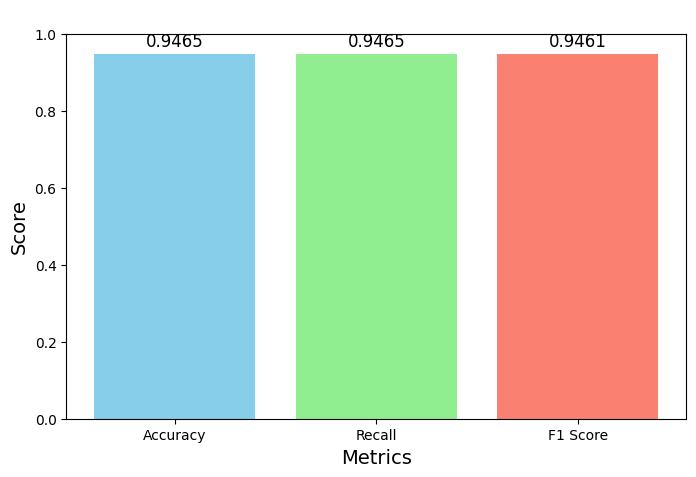

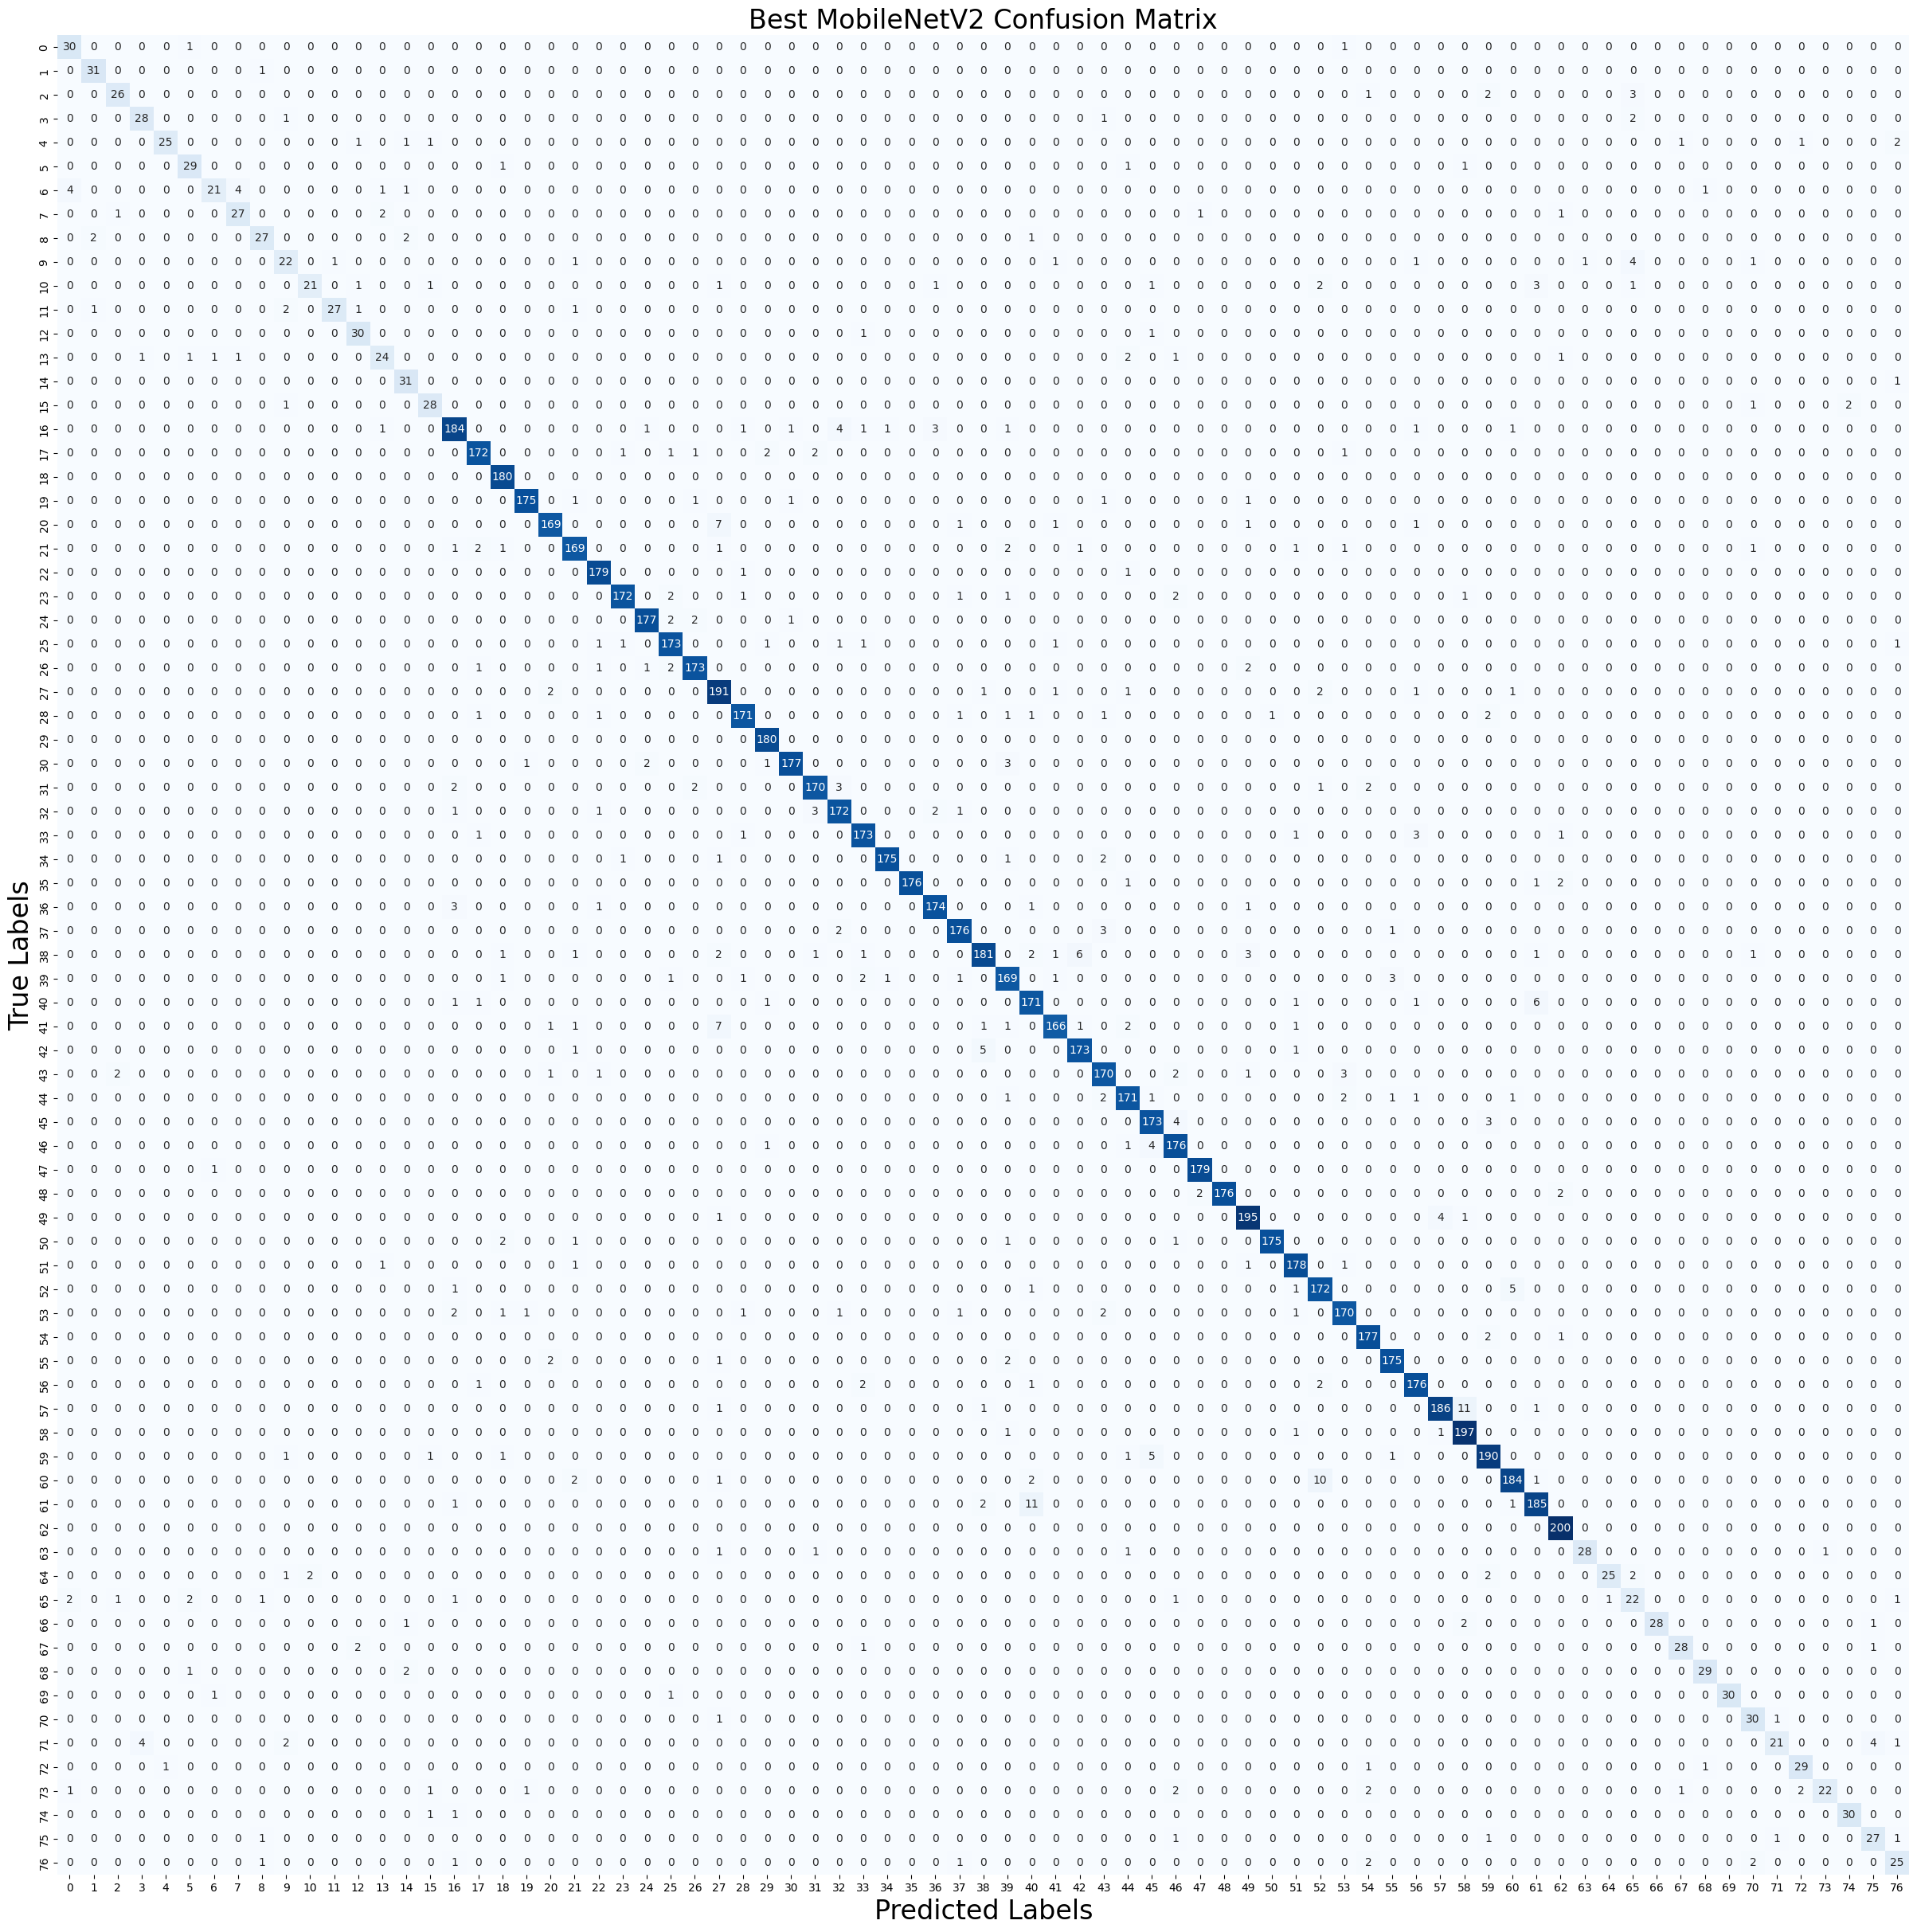

In [20]:
mobilenet_model = build_mobilenet_model(input_shape=(IMG_SIZE, IMG_SIZE, CHANNELS), num_classes=len(CLASSES))
history_mobilenet = mobilenet_model.fit(X_train, y_train_dl, validation_data=(X_test, y_test_dl), epochs=50, callbacks=callbacks, batch_size=32)

mobilenet_eval = mobilenet_model.evaluate(X_test, y_test_dl, verbose=0)
print(f"MobileNetV2 Model - Test Accuracy: {mobilenet_eval[1]:.4f}")
# MobileNetV2 Evaluation
mobilenet_predictions = mobilenet_model.predict(X_test)
display_metrics(y_test_dl.argmax(axis=1), mobilenet_predictions.argmax(axis=1), "Best MobileNetV2")
mobilenet_model.save("mobilenet_model.keras")

In [21]:
mobilenet_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 2, 2, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 5120)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       655,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 77)             │         9,933 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,254,249 (16.23 MB)

 Trainable params: 665,421 (2.54 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 1,330,844 (5.08 MB)

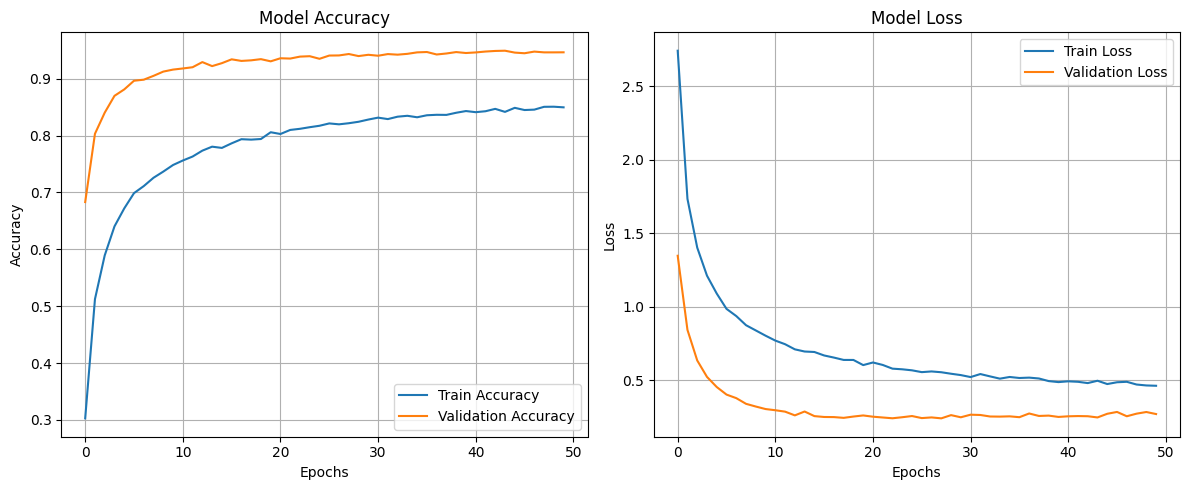

In [22]:
import matplotlib.pyplot as plt

# Plot accuracy graph
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_mobilenet.history['accuracy'], label='Train Accuracy')
plt.plot(history_mobilenet.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.grid()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_mobilenet.history['loss'], label='Train Loss')
plt.plot(history_mobilenet.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.grid()

# Show the plots
plt.tight_layout()
plt.show()


In [ ]:
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, restore_best_weights=True),
    ModelCheckpoint("vgg16_model.keras", monitor='val_accuracy', save_best_only=True, verbose=1)
]

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.1109 - loss: 3.6221 - val_accuracy: 0.4487 - val_loss: 2.2085
Epoch 2/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.3071 - loss: 2.4473 - val_accuracy: 0.6030 - val_loss: 1.6441
Epoch 3/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.4018 - loss: 2.0539 - val_accuracy: 0.6721 - val_loss: 1.3662
Epoch 4/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.4570 - loss: 1.8390 - val_accuracy: 0.7314 - val_loss: 1.0947
Epoch 5/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.4914 - loss: 1.6831 - val_accuracy: 0.7877 - val_loss: 0.9693
Epoch 6/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.5343 - loss: 1.5276 - val_accuracy: 0.8007 - val_loss: 0.8427
Epoch 7/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.5559 - loss: 1.4335 - val_accuracy: 0.8272 - val_loss: 0.7439
Epoch 8/50
1205/1205 ━━━━

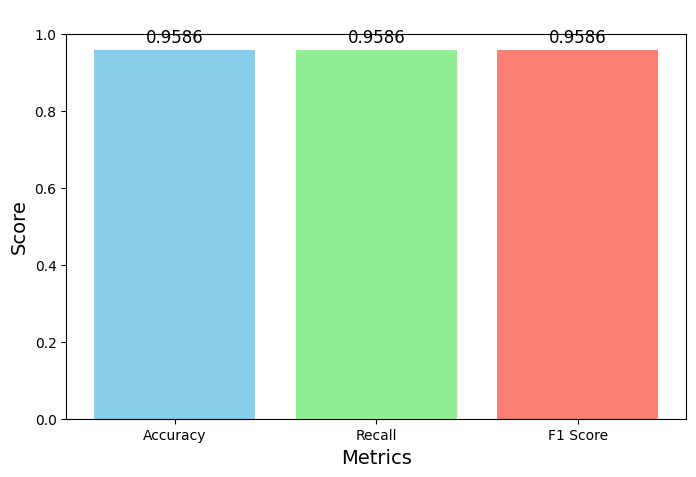

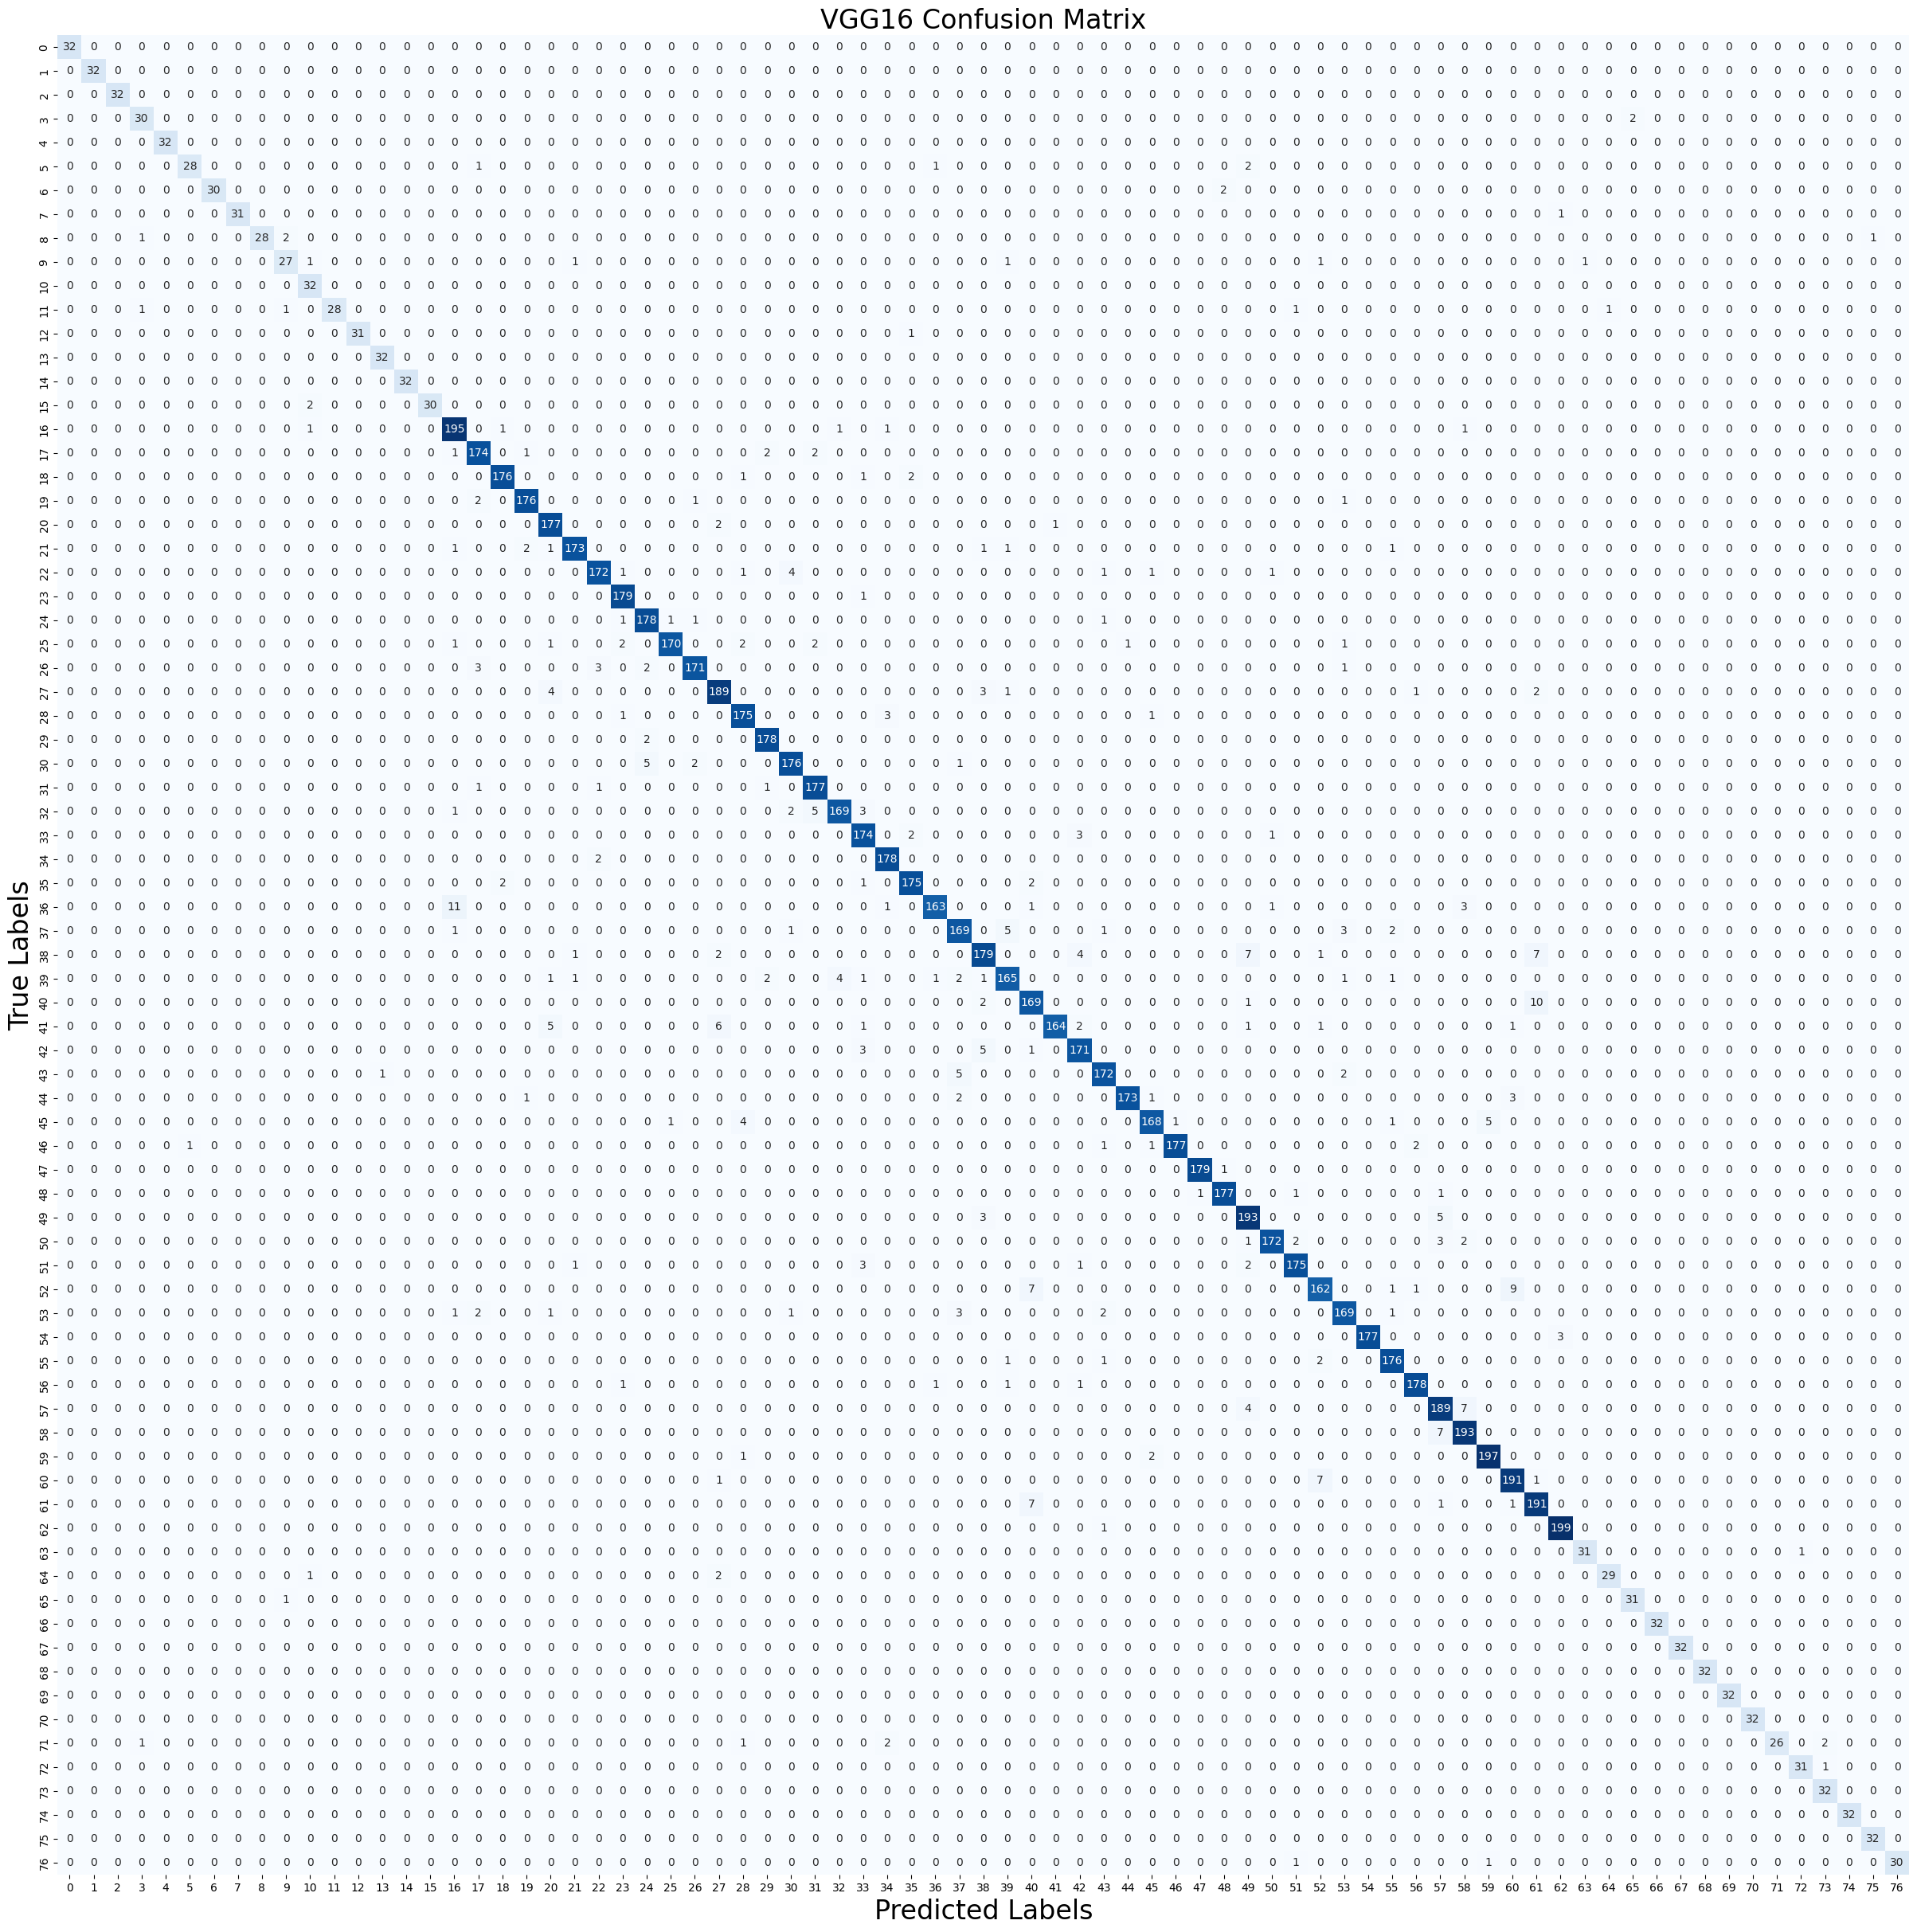

In [23]:
vgg16_model = build_vgg16_model(input_shape=(IMG_SIZE, IMG_SIZE, CHANNELS), num_classes=len(CLASSES))
history_vgg16 = vgg16_model.fit(X_train, y_train_dl, validation_data=(X_test, y_test_dl), epochs=50, callbacks=callbacks, batch_size=32)

vgg16_eval = vgg16_model.evaluate(X_test, y_test_dl, verbose=0)
print(f"VGG16 Model - Test Accuracy: {vgg16_eval[1]:.4f}")
# VGG16 Evaluation
vgg16_predictions = vgg16_model.predict(X_test)
display_metrics(y_test_dl.argmax(axis=1), vgg16_predictions.argmax(axis=1), "VGG16")
vgg16_model.save("vgg16_model.keras")

In [24]:
vgg16_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 2, 2, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 77)             │         9,933 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,531,305 (59.25 MB)

 Trainable params: 272,205 (1.04 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 544,412 (2.08 MB)

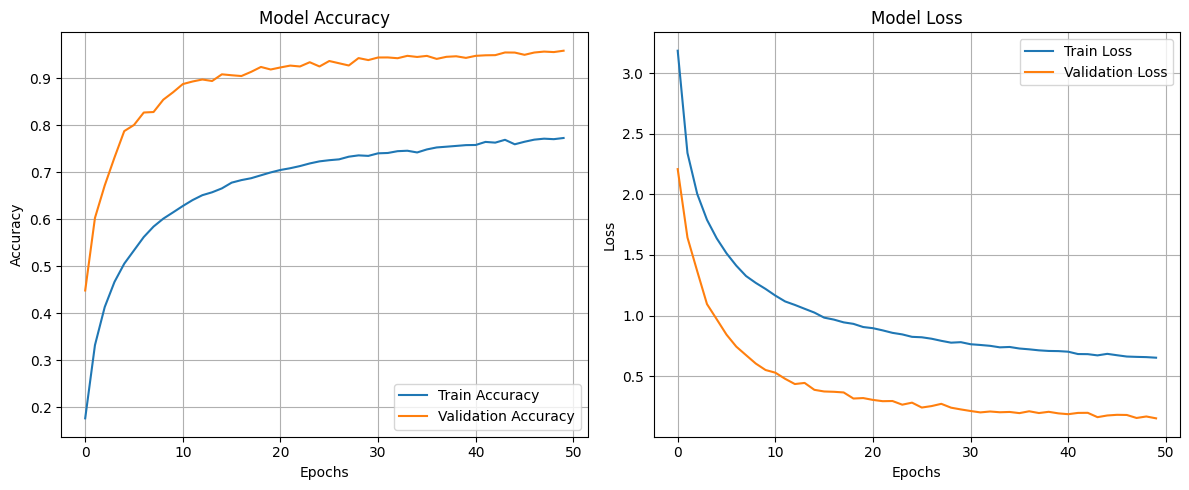

In [25]:
import matplotlib.pyplot as plt

# Plot accuracy graph
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_vgg16.history['accuracy'], label='Train Accuracy')
plt.plot(history_vgg16.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.grid()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_vgg16.history['loss'], label='Train Loss')
plt.plot(history_vgg16.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.grid()

# Show the plots
plt.tight_layout()
plt.show()


In [26]:
import joblib

{'n_neighbors': 3, 'weights': 'distance'}


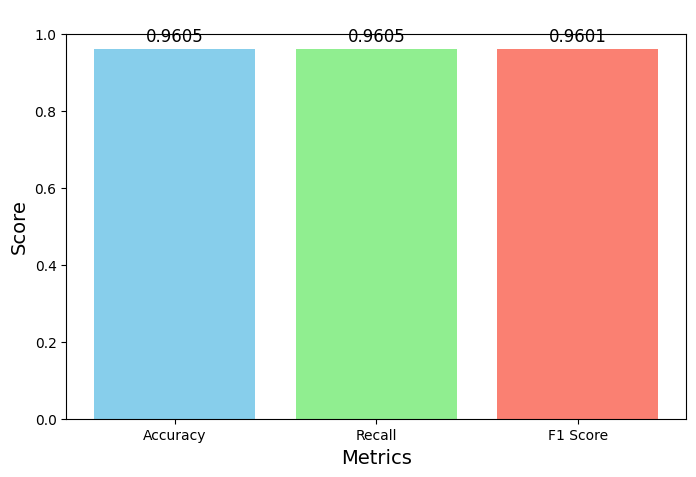

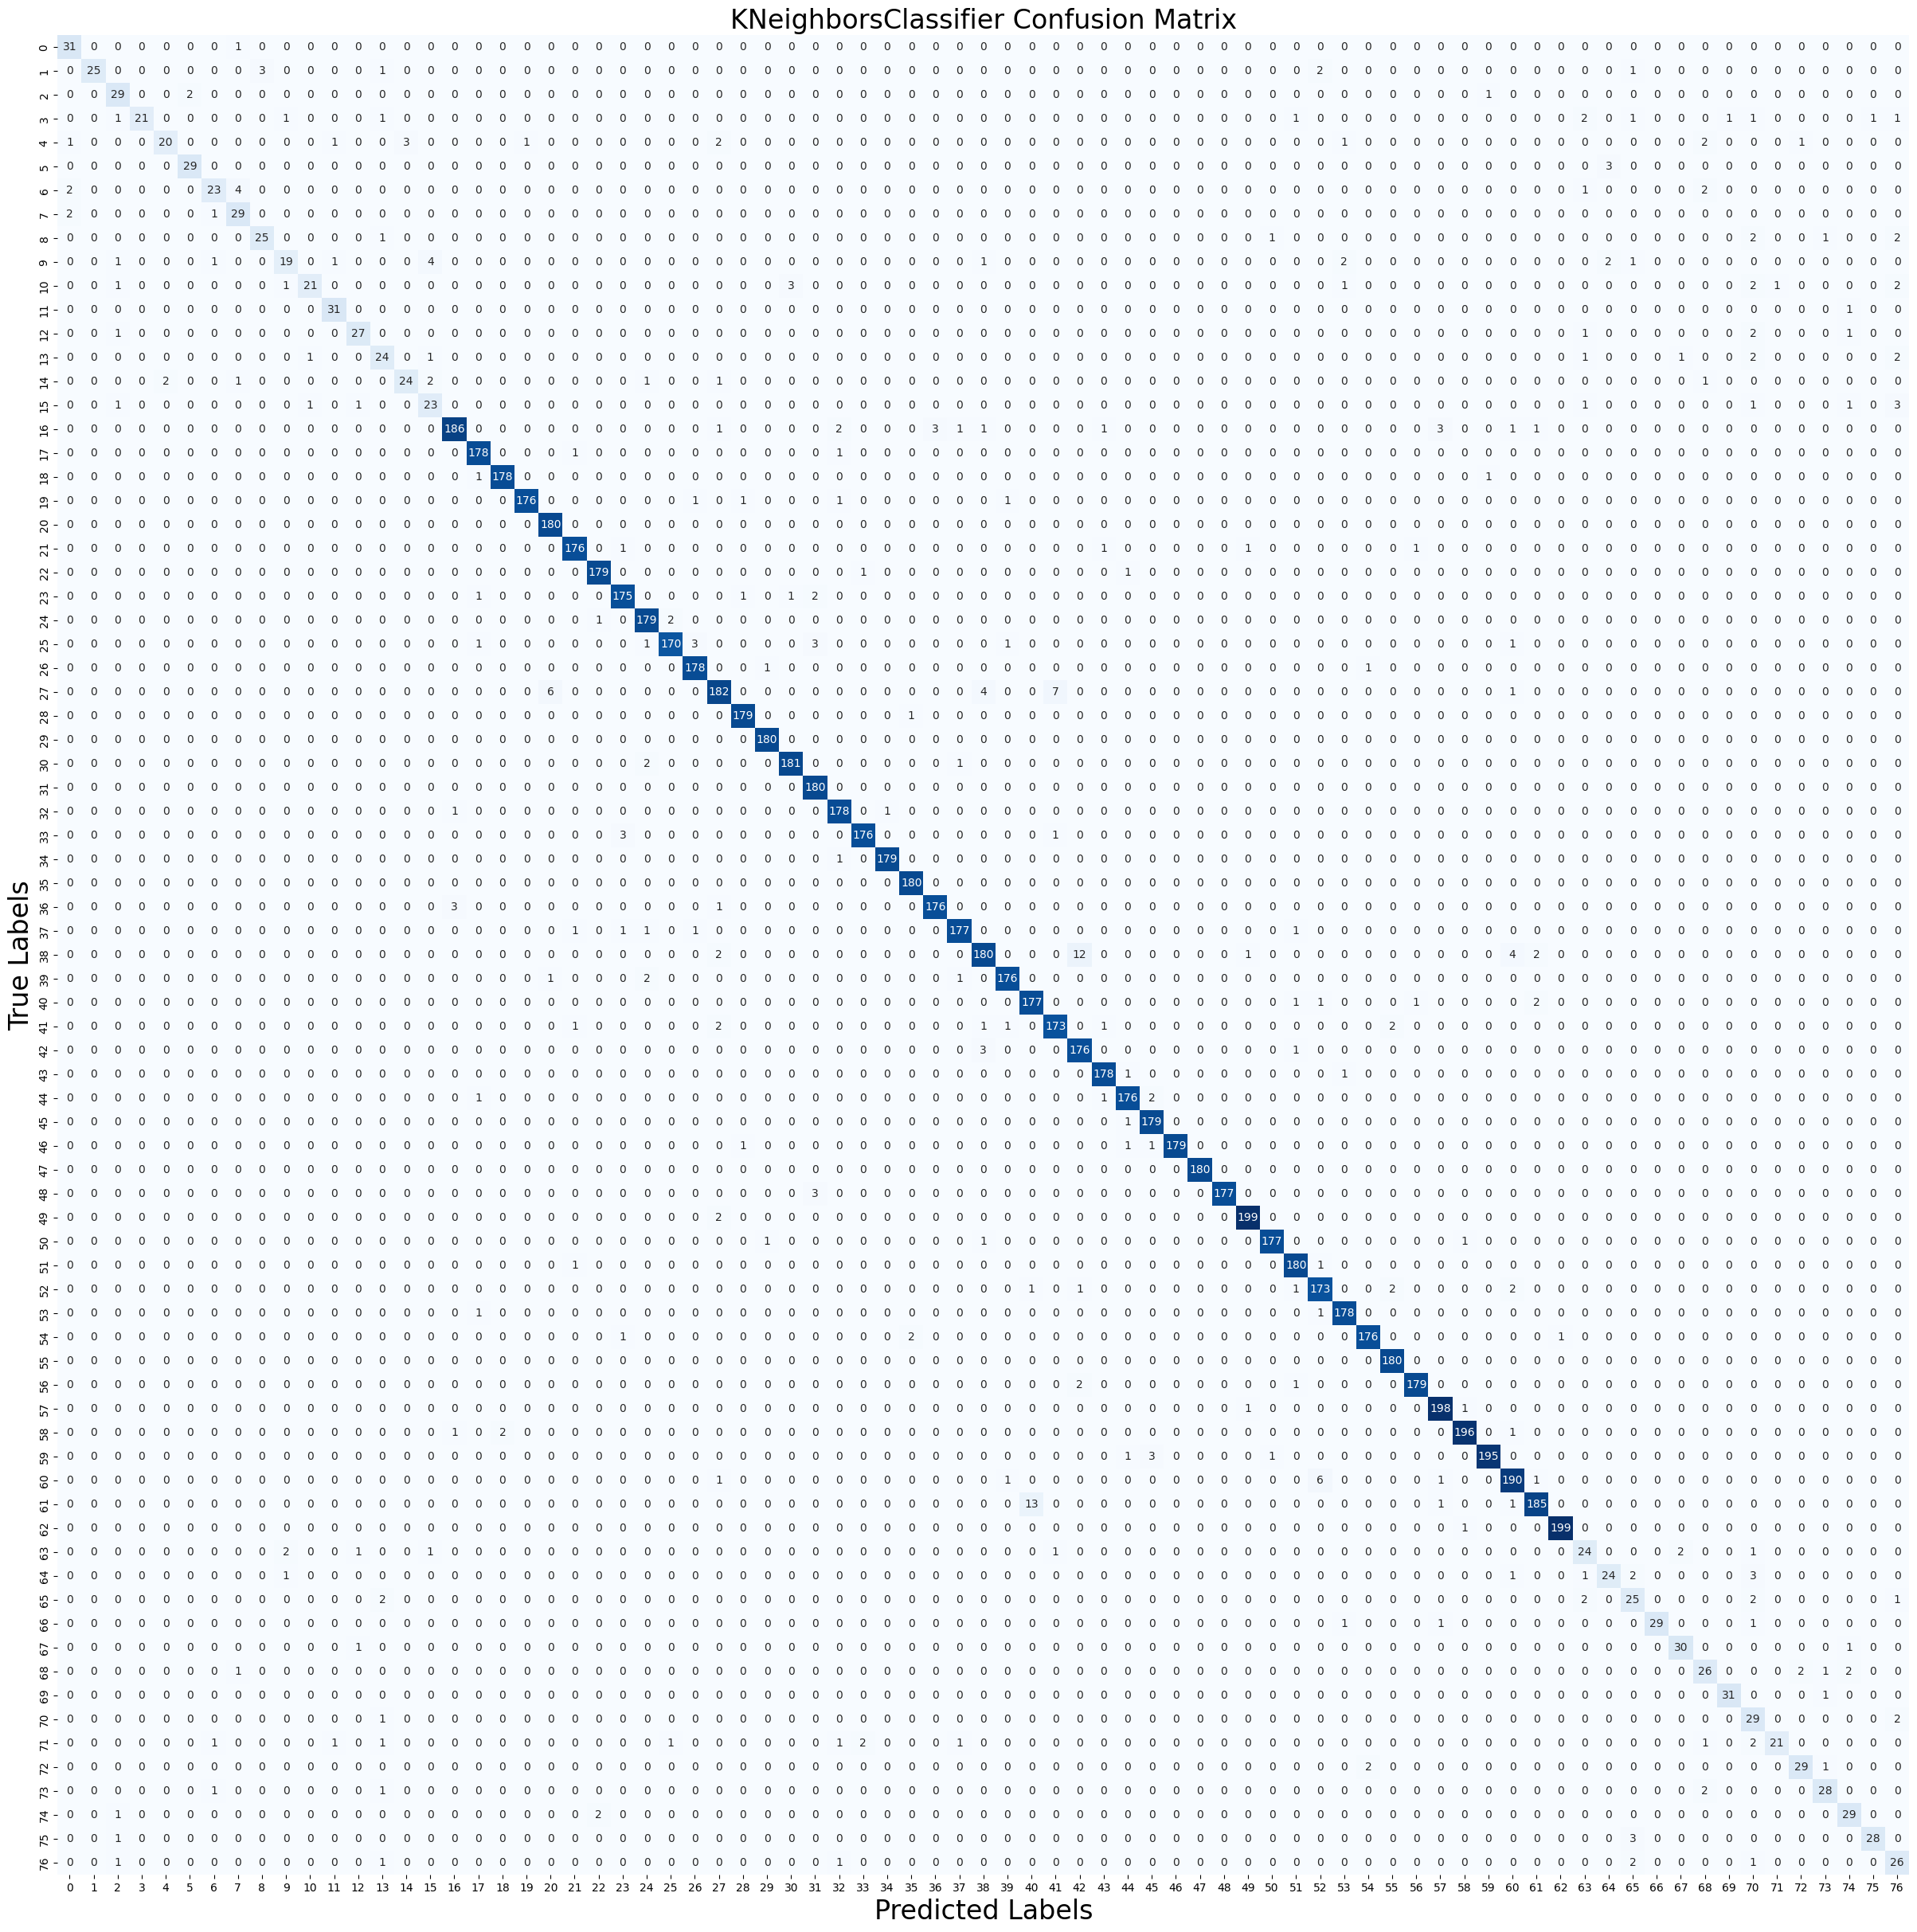

(0.9604771784232365, 0.9604771784232365, 0.9601474473784611)

In [27]:
# Machine Learning Models
# KNeighborsClassifier
knn_params = {
    'n_neighbors': [1, 3, 5, 7],
    'weights': ['uniform', 'distance'],
}
knn = GridSearchCV(KNeighborsClassifier(), knn_params, cv=5, scoring='accuracy')
knn.fit(X_train_flattened, y_train_flat)
print(knn.best_params_)
knn_best_model = knn.best_estimator_
knn_predictions = knn_best_model.predict(X_test_flattened)
display_metrics(y_test_flat, knn_predictions, "KNeighborsClassifier")
# joblib.dump(knn_best_model, 'knn_model.pkl')

In [28]:
# RandomForestClassifier
rf_params = {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20]}
rf = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=5, scoring='accuracy')
rf.fit(X_train_flattened, y_train_flat)
print(rf.best_params_)
rf_best_model = rf.best_estimator_
rf_predictions = rf_best_model.predict(X_test_flattened)
display_metrics(y_test_flat, rf_predictions, "RandomForestClassifier")
# joblib.dump(rf_best_model, 'random_forest_model.pkl')

In [35]:
# Load the mapping
with open('label_mapping.json', 'r') as f:
    index_to_label = json.load(f)

# Example prediction post-processing
def decode_prediction(pred):
    if isinstance(pred, np.ndarray):  # For deep learning models
        pred_class = np.argmax(pred, axis=1)[0]
    else:  # For ML models like KNN/RF
        pred_class = int(pred)
    
    return index_to_label[str(pred_class)]


In [36]:
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img.astype("float32") / 255.0
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

In [37]:
image_path = "/kaggle/input/dataset-of-77-bangla-sign/Final_Processed_images/Sign 28/pic_105.jpg"  # <- replace with your actual image path

new_image_batch = preprocess_image(image_path)
pred = cnn_model.predict(new_image_batch)
label = decode_prediction(pred)

print("Predicted Sign:", label)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
Predicted Sign: sign28


# Thesis Code

In [38]:
# Machine Learning Models
# KNeighborsClassifier
# knn_params = {
#     'n_neighbors': [1, 3, 5, 7],
#     'weights': ['uniform', 'distance'],
#     'metric': ['euclidean', 'manhattan'],
# }
# knn = GridSearchCV(KNeighborsClassifier(), knn_params, cv=5, scoring='accuracy')
# knn.fit(X_train_flattened, y_train_flat)
# print(knn.best_params_)
# knn_best_model = knn.best_estimator_
# knn_predictions = knn_best_model.predict(X_test_flattened)
# display_metrics(y_test_flat, knn_predictions, "KNeighborsClassifier")
# joblib.dump(knn_best_model, 'knn_model.pkl')

In [39]:
# RandomForestClassifier
# rf_params = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [None, 10, 20],
# }
# rf = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=5, scoring='accuracy')
# rf.fit(X_train_flattened, y_train_flat)
# print(rf.best_params_)
# rf_best_model = rf.best_estimator_
# rf_predictions = rf_best_model.predict(X_test_flattened)
# display_metrics(y_test_flat, rf_predictions, "RandomForestClassifier")
# joblib.dump(rf_best_model, 'random_forest_model.pkl')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, recall_score

def create_performance_comparison_plots(models, y_true_list, y_pred_list, model_names):
    """
    Create three performance comparison plots (accuracy, F1-score, recall) for multiple models
    displayed vertically
    
    Args:
        models: List of model objects
        y_true_list: List of true labels for each model
        y_pred_list: List of predicted labels for each model
        model_names: List of model names for display
    """
    # Calculate metrics for each model
    accuracies = []
    f1_scores = []
    recalls = []
    
    for y_true, y_pred in zip(y_true_list, y_pred_list):
        accuracies.append(accuracy_score(y_true, y_pred))
        f1_scores.append(f1_score(y_true, y_pred, average='weighted'))
        recalls.append(recall_score(y_true, y_pred, average='weighted'))
    
    # Convert to percentages for display
    accuracies = [x * 100 for x in accuracies]
    f1_scores = [x * 100 for x in f1_scores]
    recalls = [x * 100 for x in recalls]
    
    # Common settings for all plots
    bar_width = 0.6
    indices = np.arange(len(model_names))
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    
    # Create figure with 3 subplots vertically
    plt.figure(figsize=(8, 15))
    
    # Accuracy plot (top)
    plt.subplot(3, 1, 1)
    bars1 = plt.bar(indices, accuracies, bar_width, color=colors)
    plt.title('Accuracy Comparison', fontsize=14, pad=20)
    plt.ylabel('Accuracy (%)', fontsize=12)
    plt.xticks(indices, model_names, rotation=45, ha='right', fontsize=10)
    plt.ylim(0, 100)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add value labels on top of each bar
    # for bar in bars1:
    #     height = bar.get_height()
    #     plt.text(bar.get_x() + bar.get_width()/2., height,
    #             f'{height:.2f}%',
    #             ha='center', va='bottom', fontsize=10)
    
    # F1-score plot (middle)
    plt.subplot(3, 1, 2)
    bars2 = plt.bar(indices, f1_scores, bar_width, color=colors)
    plt.title('F1-Score Comparison', fontsize=14, pad=20)
    plt.ylabel('F1-Score (%)', fontsize=12)
    plt.xticks(indices, model_names, rotation=45, ha='right', fontsize=10)
    plt.ylim(0, 100)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # for bar in bars2:
    #     height = bar.get_height()
    #     plt.text(bar.get_x() + bar.get_width()/2., height,
    #             f'{height:.2f}%',
    #             ha='center', va='bottom', fontsize=10)
    
    # Recall plot (bottom)
    plt.subplot(3, 1, 3)
    bars3 = plt.bar(indices, recalls, bar_width, color=colors)
    plt.title('Recall Comparison', fontsize=14, pad=20)
    plt.ylabel('Recall (%)', fontsize=12)
    plt.xticks(indices, model_names, rotation=45, ha='right', fontsize=10)
    plt.ylim(0, 100)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # for bar in bars3:
    #     height = bar.get_height()
    #     plt.text(bar.get_x() + bar.get_width()/2., height,
    #             f'{height:.2f}%',
    #             ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()

# Example usage with your models:
# First collect all the true and predicted labels for each model
y_true_list = [
    y_test_dl.argmax(axis=1),  # CNN
    y_test_dl.argmax(axis=1),  # MobileNet
    y_test_dl.argmax(axis=1),  # VGG16
    y_test_flat,               # KNN
    y_test_flat                # Random Forest
]

y_pred_list = [
    cnn_predictions.argmax(axis=1),
    mobilenet_predictions.argmax(axis=1),
    vgg16_predictions.argmax(axis=1),
    knn_predictions,
    rf_predictions
]

model_names = [
    "CNN",
    "MobileNetV2",
    "VGG16",
    "KNN",
    "Random Forest"
]

# Create the comparison plots
create_performance_comparison_plots([], y_true_list, y_pred_list, model_names)